In [3]:
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import stopwords
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from nltk.stem.porter import PorterStemmer
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
import os
import joblib

In [2]:
print("Tentando baixar 'punkt_tab'...")
nltk.download('punkt_tab')
print("Tentando baixar 'stopwords'...")
nltk.download('stopwords')

# download do NLTK (só na primeira vez)
nltk.download('punkt')
nltk.download('stopwords')

Tentando baixar 'punkt_tab'...
Tentando baixar 'stopwords'...


[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# configs gerais
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# 1. CARREGAR E ENTENDER OS DADOS

In [4]:
print("Carregando dataset completo em partes...")
chunksize = 100000  # Processar em lotes de 100.000 linhas
data_chunks = []
for chunk in pd.read_csv('complaints.csv', chunksize=chunksize):
    chunk = chunk.dropna(subset=["narrative"])
    data_chunks.append(chunk)
data = pd.concat(data_chunks, ignore_index=True)

Carregando dataset completo em partes...


In [5]:
print("Primeiras 5 linhas do dataset:")
print(data.head())

Primeiras 5 linhas do dataset:
   Unnamed: 0         product_5  \
0         234  Credit Reporting   
1         240   Debt Collection   
2         257  Credit Reporting   
3         271  Credit Reporting   
4         276             Loans   

                                           narrative  \
0  Dear Possible Financial Inc you guyss aree rep...   
1  XXXX XXXX XXXX ( debt collector ), sent my boy...   
2  I been receiving alerts my information was fou...   
3  Subject : Dispute of Inaccurate Information on...   
4  They allowed me to use the account for about a...   

                                             Product Date received  \
0  Credit reporting or other personal consumer re...    2024-07-27   
1                                    Debt collection    2024-07-27   
2  Credit reporting or other personal consumer re...    2024-07-23   
3  Credit reporting or other personal consumer re...    2024-07-27   
4  Payday loan, title loan, personal loan, or adv...    2024-07-26   



In [6]:
print("\nInformações do dataset:")
print(data.info())


Informações do dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2023066 entries, 0 to 2023065
Data columns (total 11 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   Unnamed: 0        int64 
 1   product_5         object
 2   narrative         object
 3   Product           object
 4   Date received     object
 5   Sub-product       object
 6   Issue             object
 7   Sub-issue         object
 8   Company           object
 9   State             object
 10  Timely response?  object
dtypes: int64(1), object(10)
memory usage: 169.8+ MB
None


#### Características


In [7]:
print("- Origem: Consumer Financial Protection Bureau (CFPB), EUA.")
data["Date received"] = pd.to_datetime(data["Date received"])
print(f"- Periodo: de {data['Date received'].min()} a {data['Date received'].max()}")
print("- Gênero: Reclamações textuais de consumidores sobre serviços financeiros.")
print("- Língua: Inglês.")
print("- Anotação: Rótulos ('Product') atribuídos pelos consumidores ao submeter reclamações.")
print(f"- Total de reclamações: {len(data)}")
print(f"- Colunas disponíveis: {list(data.columns)}")
data = data.dropna(subset=["narrative"])
print(f"\nTotal de reclamações: {len(data)}")

- Origem: Consumer Financial Protection Bureau (CFPB), EUA.
- Periodo: de 2015-03-19 00:00:00 a 2024-07-31 00:00:00
- Gênero: Reclamações textuais de consumidores sobre serviços financeiros.
- Língua: Inglês.
- Anotação: Rótulos ('Product') atribuídos pelos consumidores ao submeter reclamações.
- Total de reclamações: 2023066
- Colunas disponíveis: ['Unnamed: 0', 'product_5', 'narrative', 'Product', 'Date received', 'Sub-product', 'Issue', 'Sub-issue', 'Company', 'State', 'Timely response?']

Total de reclamações: 2023066


# 2. ANÁLISE EXPLORATÓRIA DOS DADOS (EDA)


### Distribuição das Classes (Produtos) ###
product_5
Credit Reporting              1205275
Debt Collection                266842
Loans                          228599
Credit Card Services           163710
Bank Accounts and Services     158640
Name: count, dtype: int64
product_5
Credit Reporting              0.595767
Debt Collection               0.131900
Loans                         0.112996
Credit Card Services          0.080922
Bank Accounts and Services    0.078416
Name: count, dtype: float64


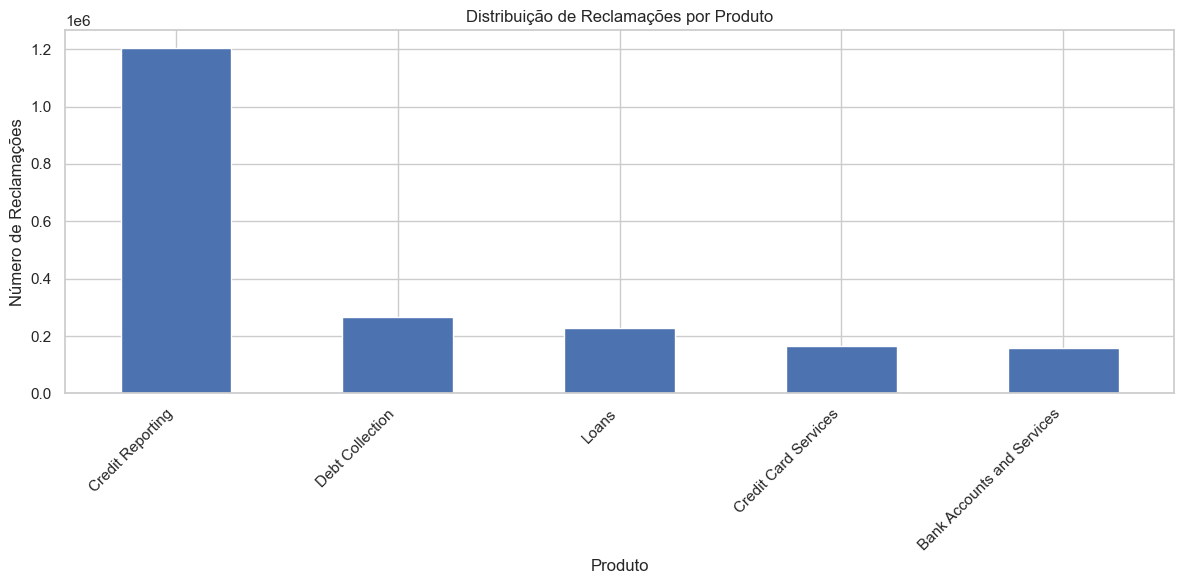

In [8]:
# a) Distribuição de classes
print("\n### Distribuição das Classes (Produtos) ###")
class_counts = data["product_5"].value_counts()
print(class_counts)
print(class_counts / len(data))  # Proporção, como no Notebook 2

# Gráfico de barras (como no Notebook 2)
plt.figure()
class_counts.plot(kind="bar")
plt.title("Distribuição de Reclamações por Produto")
plt.xlabel("Produto")
plt.ylabel("Número de Reclamações")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()



In [4]:
ps = PorterStemmer()
sw = set(stopwords.words("english"))
data = pd.read_csv('complaints.csv', nrows=50000)

In [10]:
# b) Pré-processamento (remover não alfabéticos e stopwords + converter p minúsculas + stemming: "reporting" → "report", "reports" → "report")
if "processed_text_stemmed" not in data.columns or not os.path.exists("consumer_complaints_processed_full.csv"):
    print("Pré-processando dataset completo em lotes...")
    corpus = []
    for i in range(0, len(data), chunksize):
        batch = data["narrative"][i:i + chunksize]
        batch_corpus = []
        for review in batch:
            review = re.sub('[^a-zA-Z]', ' ', str(review)).lower()
            tokens = [ps.stem(w) for w in review.split() if w not in sw]
            batch_corpus.append(' '.join(tokens))
        corpus.extend(batch_corpus)
    data["processed_text_stemmed"] = corpus
    data.to_csv("consumer_complaints_processed_full.csv", index=False)
    print("Corpus processado criado e salvo como 'consumer_complaints_processed_full.csv'.")
else:
    data = pd.read_csv("consumer_complaints_processed_full.csv")
    print("Carregando corpus processado salvo...")

Pré-processando dataset completo em lotes...
Corpus processado criado e salvo como 'consumer_complaints_processed_full.csv'.


In [11]:
# c) Comprimento das reclamações
data["word_count"] = data["processed_text_stemmed"].apply(lambda x: len(word_tokenize(x)))
print("\n### Estatísticas do Comprimento das Reclamações ###")
print(data["word_count"].describe())


### Estatísticas do Comprimento das Reclamações ###
count    50000.000000
mean        87.263400
std        125.667783
min          1.000000
25%         27.000000
50%         55.000000
75%        106.000000
max       4509.000000
Name: word_count, dtype: float64


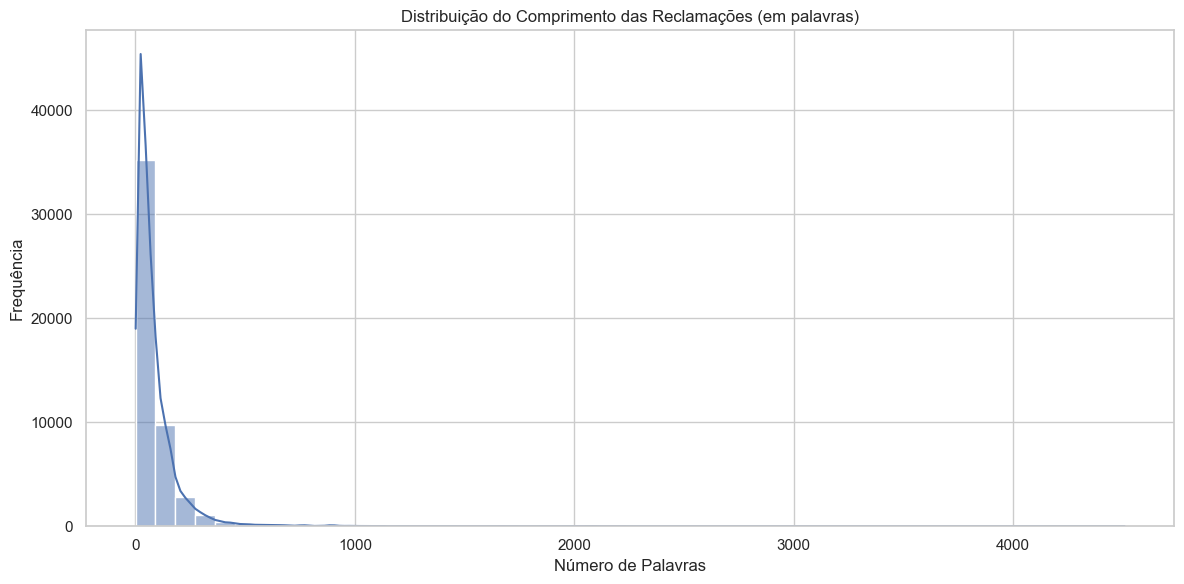

In [12]:
# Histograma (inspirado em visualizações do Notebook 2)
plt.figure()
sns.histplot(data["word_count"], bins=50, kde=True)
plt.title("Distribuição do Comprimento das Reclamações (em palavras)")
plt.xlabel("Número de Palavras")
plt.ylabel("Frequência")
plt.tight_layout()
plt.show()

In [13]:
# d) Análise de vocabulário com CountVectorizer (Notebook 2)
vectorizer = CountVectorizer(max_features=20)  # Primeiro, cria o vectorizer sem stop_words personalizados
X = vectorizer.fit_transform(data["processed_text_stemmed"]).toarray()
vocab = vectorizer.get_feature_names_out()  # Define vocab aqui

# Cria custom_stopwords usando o vocab agora definido
custom_stopwords = set(stopwords.words("english")) | {word for word in vocab if all(c == 'x' for c in word.lower())}
vectorizer = CountVectorizer(max_features=20, stop_words=list(custom_stopwords))  # Recria o vectorizer com stop_words
X = vectorizer.fit_transform(data["processed_text_stemmed"]).toarray()
vocab = vectorizer.get_feature_names_out()
print("\n### Top 20 Palavras no Vocabulário (Bag-of-Words, sem tokens de 'x') ###")
print(vocab)


### Top 20 Palavras no Vocabulário (Bag-of-Words, sem tokens de 'x') ###
['account' 'agenc' 'consum' 'credit' 'disput' 'inaccur' 'inform' 'item'
 'late' 'payment' 'person' 'pleas' 'provid' 'remov' 'report' 'request'
 'right' 'section' 'state' 'violat']



### Top 10 Bigramas Mais Frequentes ###
credit report: 54242
consum report: 31496
report agenc: 19933
fair credit: 10380
report act: 9746
ident theft: 9113
u code: 9108
late payment: 8885
c section: 8782
account number: 7993


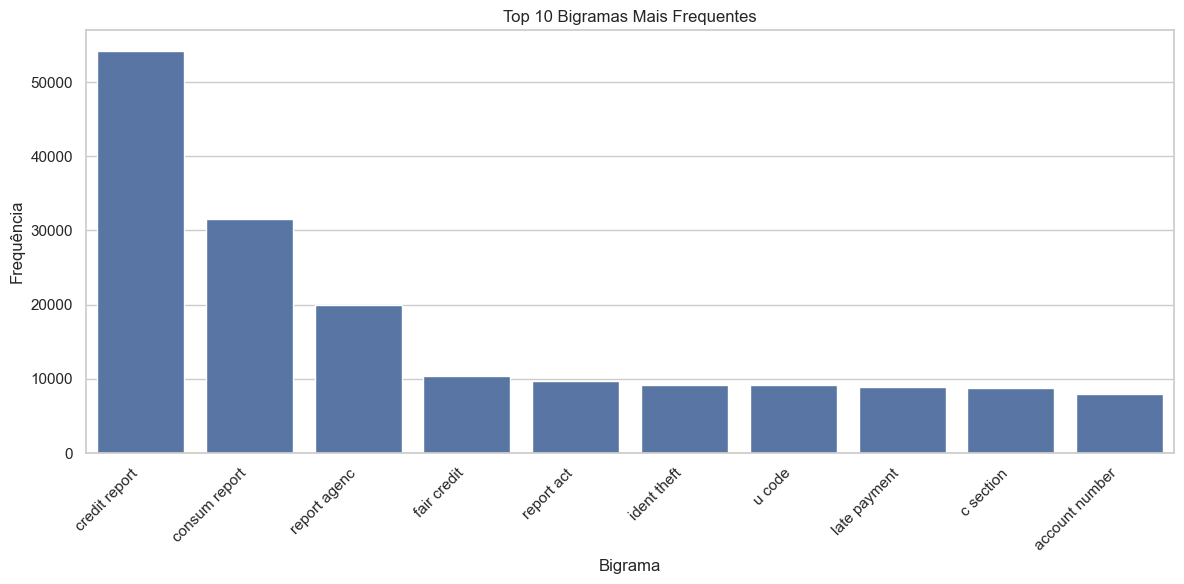

In [14]:
# e) N-gramas mais frequentes (como no Notebook 1)
bigram_counts = Counter()
batch_size = 10000 # Processar em lotes de 10.000 reclamações
for i in range(0, len(data["processed_text_stemmed"]), batch_size):
    batch_corpus = data["processed_text_stemmed"][i:i + batch_size].tolist()
    all_tokens = " ".join(batch_corpus).split()
    bigrams = (bigram for bigram in ngrams(all_tokens, 2)
               if not any(all(c == 'x' for c in str(w).lower()) for w in bigram)
               and ' '.join(bigram) != 'u c')
    bigram_counts.update(bigrams)

# Os 10 bigramas mais frequentes
bigram_counts = bigram_counts.most_common(10)

print("\n### Top 10 Bigramas Mais Frequentes ###")
for bigram, count in bigram_counts:
    print(f"{' '.join(bigram)}: {count}")

# Gráfico de barras para bigramas
bigram_labels = [" ".join(bigram[0]) for bigram in bigram_counts]
bigram_values = [bigram[1] for bigram in bigram_counts]
plt.figure()
sns.barplot(x=bigram_labels, y=bigram_values)
plt.title("Top 10 Bigramas Mais Frequentes")
plt.xlabel("Bigrama")
plt.ylabel("Frequência")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [15]:
# Salvar dataset processado
data.to_csv("consumer_complaints_processed.csv", index=False)
print("\nDataset processado salvo como 'consumer_complaints_processed.csv'.")


Dataset processado salvo como 'consumer_complaints_processed.csv'.


# 3. Undersampling (Credit Reporting para 250.000)

In [6]:
print("\nDistribuição antes undersampling:")
print(data["product_5"].value_counts())


Distribuição antes undersampling:
product_5
Credit Reporting              37871
Debt Collection                4569
Credit Card Services           2676
Bank Accounts and Services     2618
Loans                          2266
Name: count, dtype: int64


In [16]:
df_majority = data[data["product_5"] == "Credit Reporting"]
df_minority = data[data["product_5"] != "Credit Reporting"]
df_majority_downsampled = resample(df_majority,
                                  replace=False,    # Sem substituição
                                  n_samples=4500, # Reduzir 
                                  random_state=42)
data_balanced = pd.concat([df_majority_downsampled, df_minority])
print("\nDistribuição após undersampling:")
print(data_balanced["product_5"].value_counts())


Distribuição após undersampling:
product_5
Debt Collection               4569
Credit Reporting              4500
Credit Card Services          2676
Bank Accounts and Services    2618
Loans                         2266
Name: count, dtype: int64


In [17]:
# Reutilizar corpus processado
data_balanced["processed_text_stemmed"] = data_balanced["processed_text_stemmed"].fillna('').astype(str)

In [18]:
# Análise de vocabulário com CountVectorizer (Notebook 2)
vectorizer = CountVectorizer(max_features=5000, stop_words=list(custom_stopwords))
X = vectorizer.fit_transform(data_balanced["processed_text_stemmed"])
print(f"Tamanho do espaço de features (BoW): {X.shape[1]} features")

Tamanho do espaço de features (BoW): 5000 features


## 3.1 - Classificadores

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, data_balanced["product_5"], test_size=0.2, random_state=42)

In [20]:
# Baseline (Naive Bayes com BoW)
nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)
print("Baseline Naive Bayes com BoW (Undersampling):\n", classification_report(y_test, y_pred_nb, zero_division=0))

Baseline Naive Bayes com BoW (Undersampling):
                             precision    recall  f1-score   support

Bank Accounts and Services       0.80      0.89      0.84       527
      Credit Card Services       0.74      0.70      0.72       550
          Credit Reporting       0.79      0.82      0.81       907
           Debt Collection       0.83      0.76      0.80       900
                     Loans       0.77      0.81      0.79       442

                  accuracy                           0.79      3326
                 macro avg       0.79      0.80      0.79      3326
              weighted avg       0.79      0.79      0.79      3326



In [21]:
# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print("Logistic Regression com BoW (Undersampling):\n", classification_report(y_test, y_pred_lr, zero_division=0))

Logistic Regression com BoW (Undersampling):
                             precision    recall  f1-score   support

Bank Accounts and Services       0.86      0.84      0.85       527
      Credit Card Services       0.79      0.77      0.78       550
          Credit Reporting       0.83      0.81      0.82       907
           Debt Collection       0.79      0.86      0.82       900
                     Loans       0.80      0.74      0.77       442

                  accuracy                           0.81      3326
                 macro avg       0.81      0.80      0.81      3326
              weighted avg       0.81      0.81      0.81      3326



## 3.2 - Classificadores com N-Grams como features

In [22]:
# N-grams (unigramas e bigramas) como features
vectorizer_ngrams = CountVectorizer(max_features=5000, ngram_range=(1, 2), stop_words=list(custom_stopwords))
X_ngrams = vectorizer_ngrams.fit_transform(data_balanced["processed_text_stemmed"])
print(f"Tamanho do espaço de features com N-grams: {X_ngrams.shape[1]}")

Tamanho do espaço de features com N-grams: 5000


In [23]:
X_train_ng, X_test_ng, y_train_ng, y_test_ng = train_test_split(X_ngrams, data_balanced["product_5"], test_size=0.2, random_state=42)

In [24]:
# Naïve Bayes com N-grams
nb = MultinomialNB()
nb.fit(X_train_ng, y_train_ng)
y_pred_nb_ng = nb.predict(X_test_ng)
print("Naive Bayes com N-grams (Undersampling):\n", classification_report(y_test_ng, y_pred_nb_ng, zero_division=0))

Naive Bayes com N-grams (Undersampling):
                             precision    recall  f1-score   support

Bank Accounts and Services       0.83      0.91      0.87       527
      Credit Card Services       0.73      0.77      0.75       550
          Credit Reporting       0.83      0.79      0.81       907
           Debt Collection       0.84      0.76      0.79       900
                     Loans       0.75      0.84      0.79       442

                  accuracy                           0.80      3326
                 macro avg       0.80      0.81      0.80      3326
              weighted avg       0.80      0.80      0.80      3326



In [25]:
# Logistic Regression N-grams
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_ng, y_train_ng)
y_pred_lr_ng = lr.predict(X_test_ng)
print("Logistic Regression com BoW (Undersampling):\n", classification_report(y_test_ng, y_pred_lr_ng, zero_division=0))

Logistic Regression com BoW (Undersampling):
                             precision    recall  f1-score   support

Bank Accounts and Services       0.85      0.86      0.86       527
      Credit Card Services       0.78      0.78      0.78       550
          Credit Reporting       0.84      0.80      0.82       907
           Debt Collection       0.80      0.86      0.83       900
                     Loans       0.81      0.75      0.78       442

                  accuracy                           0.82      3326
                 macro avg       0.82      0.81      0.81      3326
              weighted avg       0.82      0.82      0.82      3326



In [26]:
# Salvar dataset processado
data_balanced.to_csv("consumer_complaints_undersampled.csv", index=False)
print("\nDataset processado salvo como 'consumer_complaints_undersampled.csv'.")


Dataset processado salvo como 'consumer_complaints_undersampled.csv'.


# 4. Undersampling + Oversampling (SMOTE com TF-IDF)

In [27]:
df_majority = data[data["product_5"] == "Credit Reporting"]
df_minority = data[data["product_5"] != "Credit Reporting"]
df_majority_downsampled = resample(df_majority,
                                  replace=False,
                                  n_samples=10000,  # Reduzir para 400.000
                                  random_state=42)

In [28]:
# Reutilizar corpus processado
df_majority_downsampled["processed_text_stemmed"] = df_majority_downsampled["processed_text_stemmed"].fillna('').astype(str)
df_minority["processed_text_stemmed"] = df_minority["processed_text_stemmed"].fillna('').astype(str)

C:\Users\User\AppData\Local\Temp\ipykernel_14472\154207512.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_minority["processed_text_stemmed"] = df_minority["processed_text_stemmed"].fillna('').astype(str)


In [29]:
# Transformar texto em features TF-IDF mas em lotes para evitar memory error
import scipy

print("Aplicando TF-IDF em lotes...")
tfidf = TfidfVectorizer(max_features=5000, stop_words=list(custom_stopwords))
X_tfidf_chunks = []
for i in range(0, len(pd.concat([df_majority_downsampled, df_minority])), chunksize):
    batch = pd.concat([df_majority_downsampled, df_minority])["processed_text_stemmed"][i:i + chunksize]
    X_tfidf_chunks.append(tfidf.fit_transform(batch))
X_tfidf = scipy.sparse.vstack(X_tfidf_chunks)
y = pd.concat([df_majority_downsampled["product_5"], df_minority["product_5"]])

Aplicando TF-IDF em lotes...


In [30]:
# Aplicar SMOTE após TF-IDF
smote = SMOTE(random_state=42, sampling_strategy={c: 10000 for c in df_minority["product_5"].unique()})
X_tfidf_res, y_res = smote.fit_resample(X_tfidf, y)

In [31]:
# Criar DataFrame com dados balanceados
data_resampled = pd.DataFrame({
    "processed_text_stemmed": [' '.join(tokens) for tokens in tfidf.inverse_transform(X_tfidf_res)],
    "product_5": y_res
})
oversampled_file = "consumer_complaints_undersampled_oversampled_smote.csv.gz"
data_resampled.to_csv(oversampled_file, index=False, compression='gzip')

In [32]:
print("\nDistribuição após undersampling + oversampling (SMOTE):")
print(y_res.value_counts())


Distribuição após undersampling + oversampling (SMOTE):
product_5
Credit Reporting              10000
Debt Collection               10000
Loans                         10000
Bank Accounts and Services    10000
Credit Card Services          10000
Name: count, dtype: int64


## 4.1 - Classificadores

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf_res, y_res, test_size=0.2, random_state=42)

In [34]:
# Baseline (Naive Bayes com BoW)
nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)
print("Baseline Naive Bayes com TF-IDF (Undersampling + SMOTE):\n", classification_report(y_test, y_pred_nb, zero_division=0))

Baseline Naive Bayes com TF-IDF (Undersampling + SMOTE):
                             precision    recall  f1-score   support

Bank Accounts and Services       0.83      0.95      0.89      1954
      Credit Card Services       0.85      0.79      0.82      2038
          Credit Reporting       0.81      0.84      0.82      2043
           Debt Collection       0.87      0.76      0.81      2008
                     Loans       0.88      0.90      0.89      1957

                  accuracy                           0.85     10000
                 macro avg       0.85      0.85      0.85     10000
              weighted avg       0.85      0.85      0.85     10000



In [35]:
# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print("Logistic Regression com TF-IDF (Undersampling + SMOTE):\n", classification_report(y_test, y_pred_lr, zero_division=0))

Logistic Regression com TF-IDF (Undersampling + SMOTE):
                             precision    recall  f1-score   support

Bank Accounts and Services       0.94      0.96      0.95      1954
      Credit Card Services       0.92      0.92      0.92      2038
          Credit Reporting       0.87      0.87      0.87      2043
           Debt Collection       0.88      0.88      0.88      2008
                     Loans       0.94      0.94      0.94      1957

                  accuracy                           0.91     10000
                 macro avg       0.91      0.91      0.91     10000
              weighted avg       0.91      0.91      0.91     10000



## 4.2 - Classificadores com N-Grams como features

In [36]:
# N-grams (unigramas e bigramas) com TF-IDF
print("Aplicando TF-IDF com N-grams em lotes...")
tfidf_ngrams = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), stop_words=list(custom_stopwords))
X_tfidf_ngrams_chunks = []
for i in range(0, len(data_resampled), chunksize):
    batch = data_resampled["processed_text_stemmed"][i:i + chunksize]
    X_tfidf_ngrams_chunks.append(tfidf_ngrams.fit_transform(batch))
X_tfidf_ngrams = scipy.sparse.vstack(X_tfidf_ngrams_chunks)
joblib.dump(tfidf_ngrams, 'tfidf_ngrams_vectorizer.joblib')

Aplicando TF-IDF com N-grams em lotes...


['tfidf_ngrams_vectorizer.joblib']

In [37]:
# Aplicar SMOTE novamente para consistência
X_tfidf_ngrams_res, y_ngrams_res = smote.fit_resample(X_tfidf_ngrams, y_res)  # Usar y_res do SMOTE anterior
print(f"Tamanho do espaço de features com N-grams (TF-IDF): {X_tfidf_ngrams_res.shape[1]}")

Tamanho do espaço de features com N-grams (TF-IDF): 5000


In [38]:
X_train_ng, X_test_ng, y_train_ng, y_test_ng = train_test_split(X_tfidf_ngrams_res, y_ngrams_res, test_size=0.2, random_state=42)

In [39]:
# Naïve Bayes com N-grams
nb = MultinomialNB()
nb.fit(X_train_ng, y_train_ng)
y_pred_nb_ng = nb.predict(X_test_ng)
print("Naive Bayes com N-grams e TF-IDF (Undersampling + SMOTE):\n", classification_report(y_test_ng, y_pred_nb_ng, zero_division=0))
joblib.dump(nb, 'naive_bayes_ngrams_tfidf.joblib')

Naive Bayes com N-grams e TF-IDF (Undersampling + SMOTE):
                             precision    recall  f1-score   support

Bank Accounts and Services       0.82      0.92      0.87      1954
      Credit Card Services       0.84      0.76      0.80      2038
          Credit Reporting       0.78      0.93      0.85      2043
           Debt Collection       0.88      0.65      0.75      2008
                     Loans       0.86      0.89      0.87      1957

                  accuracy                           0.83     10000
                 macro avg       0.84      0.83      0.83     10000
              weighted avg       0.83      0.83      0.83     10000



['naive_bayes_ngrams_tfidf.joblib']

In [40]:
# Logistic Regression com N-grams
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_ng, y_train_ng)
y_pred_lr_ng = lr.predict(X_test_ng)
print("Logistic Regression com TF-IDF (Undersampling + SMOTE):\n", classification_report(y_test_ng, y_pred_lr_ng, zero_division=0))
joblib.dump(lr, 'logistic_regression_ngrams_tfidf.joblib')

Logistic Regression com TF-IDF (Undersampling + SMOTE):
                             precision    recall  f1-score   support

Bank Accounts and Services       0.95      0.96      0.95      1954
      Credit Card Services       0.93      0.92      0.92      2038
          Credit Reporting       0.89      0.92      0.90      2043
           Debt Collection       0.92      0.88      0.90      2008
                     Loans       0.95      0.95      0.95      1957

                  accuracy                           0.93     10000
                 macro avg       0.93      0.93      0.93     10000
              weighted avg       0.93      0.93      0.93     10000



['logistic_regression_ngrams_tfidf.joblib']

In [41]:
# Salvar dataset processado
#data_resampled.to_csv("consumer_complaints_undersampled_oversampled_smote.csv", index=False)
print("\nDataset processado não salvo para economizar espaço, descomente se necessário.")


Dataset processado não salvo para economizar espaço, descomente se necessário.
